In [59]:
import os
import sys
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

unflagged_data = False

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import DESPIKED_DATA_DIRECTORY
from utils.config_files import load_json_config
from utils.import_data import import_acropolis_site_data
from config.sites_deloyment_times import deployment_times

assert(os.path.exists(DESPIKED_DATA_DIRECTORY))

# load files
config = load_json_config("config.json")

In [60]:
# import all sites with column "site" added
df_sites = []

# add datetime information
spring = range(80, 172)
summer = range(172, 264)
fall = range(264, 355)
winter = list(range(355, 367)) + list(range(0, 80))

for site in config["icos_cities_portal"]["site_names"]:

    df_site = import_acropolis_site_data(target_directory=DESPIKED_DATA_DIRECTORY,
                                            deployment_times=deployment_times,
                                            site_name=site) \
            .filter(pl.col("Flag") == "U") \
            .select(["datetime", "gmp343_corrected"]) 
                
    q_low = df_site.select([pl.col("gmp343_corrected").quantile(0.025)]).item()
    q_high = df_site.select(pl.col("gmp343_corrected").quantile(0.975)).item()
                
    df_site = df_site.filter((pl.col("gmp343_corrected") >= q_low) & (pl.col("gmp343_corrected") <= q_high)) \
            .with_columns(site = pl.lit(site)) \
            .with_columns(
            pl.col("datetime")
            .dt.convert_time_zone("Europe/Berlin")
            .alias("datetime_local")) \
            .with_columns(pl.col("datetime_local").dt.ordinal_day().alias("day_of_year"),
                          pl.col("datetime_local").dt.hour().alias("hour_of_day")) \
            .with_columns(
                pl.when(pl.col("day_of_year").is_in(spring)).then(pl.lit("spring"))
                .when(pl.col("day_of_year").is_in(summer)).then(pl.lit("summer"))
                .when(pl.col("day_of_year").is_in(fall)).then(pl.lit("fall"))
                .when(pl.col("day_of_year").is_in(winter)).then(pl.lit("winter"))
                .otherwise(None)
                .alias("season")
            ).group_by(["site", "season", "hour_of_day"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("gmp343_corrected")) \
            .group_by(["site", "season"]) \
            .agg(
                pl.col("gmp343_corrected").mean().alias("mean_co2"),
                pl.col("gmp343_corrected").median().alias("median_co2"),
                pl.col("gmp343_corrected").max().alias("max_co2"),
                pl.col("gmp343_corrected").min().alias("min_co2"),
                (pl.col("gmp343_corrected").max()- pl.col("gmp343_corrected").min()).alias("variation_co2"),
                pl.col("gmp343_corrected").std().alias("std_co2"),
                pl.col("gmp343_corrected").count().alias("count_co2"))
            
    df_sites.append(df_site)
    
df = pl.concat(df_sites)

In [61]:
df

site,season,mean_co2,median_co2,max_co2,min_co2,variation_co2,std_co2,count_co2
str,str,f64,f64,f64,f64,f64,f64,u32
"""TUMR""","""winter""",454.739287,455.871755,461.543801,447.083343,14.460458,4.494018,24
"""TUMR""","""summer""",442.052924,440.256648,462.069331,427.931106,34.138226,12.393997,24
"""TUMR""","""spring""",442.744483,441.491298,458.292093,432.258892,26.033201,9.06197,24
"""TUMR""","""fall""",453.094861,453.557065,459.672077,446.909168,12.762909,3.723357,24
"""FELR""","""fall""",454.721422,456.425231,464.043589,443.827348,20.216241,5.939695,24
…,…,…,…,…,…,…,…,…
"""HARR""","""summer""",447.983188,441.26942,478.512576,428.678312,49.834264,18.367937,24
"""HARR""","""spring""",444.51625,443.02179,460.234505,433.32247,26.912034,9.592789,24
"""BALR""","""fall""",461.678529,462.895903,469.549436,451.691315,17.858122,4.948683,24


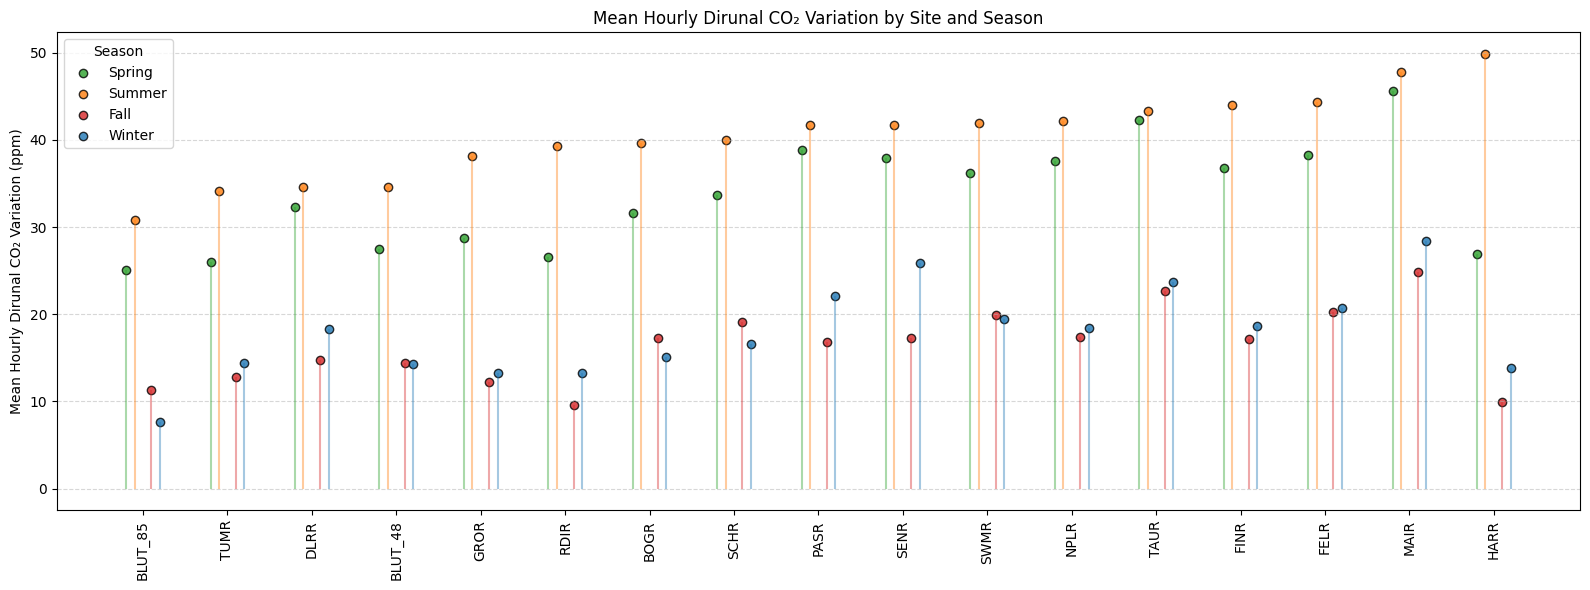

In [74]:
# Define colors and offsets
season_order = ["spring", "summer", "fall", "winter"]

# Sort sites by summer mean_co2
sites_order = (
df.filter(pl.col("season") == "summer")
    .sort("variation_co2")
    .select("site")
    .to_series()
    .to_list()
)

season_colors = {
    "spring": "tab:green",
    "summer": "tab:orange",
    "fall":   "tab:red",
    "winter": "tab:blue"
}
offsets = {
    "spring": -0.2,
    "summer": -0.1,
    "fall":    0.1,
    "winter":  0.2
}

# Create site → index mapping
site_index_df = pl.DataFrame({
    "site": sites_order,
    "site_index": list(range(len(sites_order)))
})

# Join index into Polars DataFrame
df = df.join(site_index_df, on="site", how="inner")

# Add offset column for x-position
offset_expr = (
    pl.when(pl.col("season") == "spring").then(offsets["spring"])
    .when(pl.col("season") == "summer").then(offsets["summer"])
    .when(pl.col("season") == "fall").then(offsets["fall"])
    .when(pl.col("season") == "winter").then(offsets["winter"])
    .otherwise(0.0)
)

df = df.with_columns(
    (pl.col("site_index") + offset_expr).alias("x_val")
)

# Prepare plot
x_pos = np.arange(len(sites_order))
plt.figure(figsize=(16, 6))

for season in season_order:
    subset = df.filter(pl.col("season") == season)

    x_vals = subset["x_val"].to_numpy()
    y_vals = subset["variation_co2"].to_numpy()

    # Draw vertical lines from x-axis to each point
    plt.vlines(
        x=x_vals,
        ymin=0,
        ymax=y_vals,
        color=season_colors[season],
        alpha=0.4,
        linewidth=1.5
    )

    # Plot the actual points
    plt.scatter(
        x_vals,
        y_vals,
        label=season.capitalize(),
        color=season_colors[season],
        alpha=0.8,
        edgecolor="black"
    )
    
plt.xticks(
    ticks=np.arange(len(sites_order)),
    labels=sites_order,
    rotation=90
)
plt.ylabel("Mean Hourly Dirunal CO₂ Variation (ppm)")
plt.title("Mean Hourly Dirunal CO₂ Variation by Site and Season")
plt.legend(title="Season")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()